# Progetto social
## Realizzazione di grafi riguardanti le pubblicazioni degli articoli del dipartimento scientifico
Ricerca tramite piattaforma Scopus di pubblicazioni di articoli scientifici dell'università di udine e analisi dei dati.
### Analisi del dataset
Caricamento dataset e valutazione attendibilità dei paramtri


In [19]:
# Lista delle librerie da controllare
import importlib
import subprocess
import sys

# Dizionario: nome_pip -> nome_import
required_packages = {
    "pandas": "pandas",
    "networkx": "networkx",
    "pyvis": "pyvis",
    "matplotlib": "matplotlib",
    "numpy": "numpy",
    "plotly": "plotly",
    "ipython": "IPython",
    "scipy": "scipy"
}

for pip_name, import_name in required_packages.items():
    try:
        importlib.import_module(import_name)
        print(f"{pip_name} già installato ✅")
    except ImportError:
        print(f"{pip_name} non trovato. Installazione in corso...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_name]
        )
        print(f"{pip_name} installato correttamente ✅")

pandas già installato ✅
networkx già installato ✅
pyvis già installato ✅
matplotlib già installato ✅
numpy già installato ✅
plotly già installato ✅
ipython già installato ✅
scipy già installato ✅


In [20]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
from IPython.display import display
import itertools
import plotly.graph_objects as go
import scipy
from plotly.subplots import make_subplots
import re

In [21]:
#caricamento dataset grezzo
df=pd.read_csv('dataset.csv')
df.head()

Authors  \
0                           Lancia, G.; Dalpasso, M.   
1  Da Ros, F.; Di Gaspero, L.; Kletzander, L.; La...   
2  Bacchetti, E.; de Nardin, A.; Giannarini, G.; ...   
3  Ozkilinc, O.; Soler, M.A.; Giannozzi, P.; Apar...   
4              Faletič, S.; Micheli, M.; Pospiec, G.   

                                   Author full names  \
0  Lancia, Giuseppe G. (6701584197); Dalpasso, Ma...   
1  Da Ros, Francesca (58134137500); Di Gaspero, L...   
2  Bacchetti, Emiliano (59995162800); de Nardin, ...   
3  Ozkilinc, Ozge (58138235700); Soler, Miguel A....   
4  Faletič, Sergej (56595108900); Micheli, Marisa...   

                                        Author(s) ID  \
0                             6701584197; 6603897248   
1  58134137500; 6505944235; 57194560339; 57188717...   
2  59995162800; 57259162600; 55883317500; 2448058...   
3  58138235700; 8718855800; 7004488307; 572046647...   
4              56595108900; 59664609000; 59665606800   

                                               Title  Year  \
0  Speeding Up Floyd–Warshall’s Algorithm to Comp...  2025   
1  Dynamic Temperature Control of Simulated Annea...  2025   
2  A Deep Learning Model Integrating Clinical and...  2025   
3  The Single-Parameter Bragg–Williams Model for ...  2025   
4  Teaching and learning quantum entanglement: a ...  2025   

                                  Source title Volume Issue Art. No.  \
0                                   Algorithms     18     9      560   
1                                          NaN    NaN   NaN      NaN   
2                                      Cancers     17    13     2257   
3  International Journal of Molecular Sciences     26     3      997   
4        Journal of Physics: Conference Series   2950     1   012025   

  Page start  ...                          ISBN  CODEN   PubMed ID  \
0        NaN  ...                           NaN    NaN         NaN   
1        184  ...                 9798400714658    NaN         NaN   
2        NaN  ...                           NaN    NaN         NaN   
3        NaN  ...                           NaN    NaN  39940766.0   
4        NaN  ...  9788394593742; 9781628905861    NaN         NaN   

  Language of Original Document                   Abbreviated Source Title  \
0                       English                                 Algorithms   
1                       English  GECCO - Proc. Genetic Evol. Comput. Conf.   
2                       English                                    Cancers   
3                       English                          Int. J. Mol. Sci.   
4                       English                        J. Phys. Conf. Ser.   

      Document Type Publication Stage  \
0           Article             Final   
1  Conference paper             Final   
2           Article             Final   
3           Article             Final   
4  Conference paper             Final   

                                         Open Access  Source  \
0                  All Open Access; Gold Open Access  Scopus   
1                                                NaN  Scopus   
2  All Open Access; Gold Open Access; Green Accep...  Scopus   
3  All Open Access; Gold Open Access; Green Accep...  Scopus   
4                  All Open Access; Gold Open Access  Scopus   

                   EID  
0  2-s2.0-105017372448  
1  2-s2.0-105013077196  
2  2-s2.0-105010643815  
3   2-s2.0-85217742685  
4   2-s2.0-85219573912  

[5 rows x 46 columns]

In [22]:
#Test e analisi per pulizia dataframe
num_articoli = df.shape[0] #numero aritcoli
null_counts = df.isnull().sum() #Conta valori nulli per colonna
zero_counts = (df == 0).sum() # Conta valori pari a 0 per colonna
print(f"Numero di articoli: {num_articoli}")
#Riepilogo dei valori mancanti
missing_summary = pd.DataFrame({
    "null_values": null_counts,
    "zero_values": zero_counts
})
print(missing_summary)

# Soglia: un terzo dei valori
limite = len(df)/3
cols_to_drop = []# Lista delle colonne da eliminare
for col in df.columns:
    num_null = df[col].isna().sum()
    num_zero = 0
    if pd.api.types.is_numeric_dtype(df[col]):
        num_zero = (df[col] == 0).sum()
    unique_vals = df[col].dropna().unique() #toglie le colonne con un solo valore ripetuto
    if len(unique_vals) <= 1:
        cols_to_drop.append(col)
    # Se la somma di nulli + zeri supera limite, togli la colonna
    if (num_null + num_zero) >= limite:
        cols_to_drop.append(col)
df_clean = df.drop(columns=cols_to_drop)
df_clean.to_csv("nuovo_dataset.csv", index=False)
cols_to_drop


Numero di articoli: 143
                               null_values  zero_values
Authors                                  0            0
Author full names                        0            0
Author(s) ID                             0            0
Title                                    0            0
Year                                     0            0
Source title                            20            0
Volume                                  23            0
Issue                                   77            0
Art. No.                                95            0
Page start                              62            0
Page end                                63            0
Page count                               0          143
Cited by                                 0           27
DOI                                     12            0
Link                                     0            0
Affiliations                             0            0
Authors with affiliation

['Issue',
 'Art. No.',
 'Page start',
 'Page end',
 'Page count',
 'Page count',
 'Molecular Sequence Numbers',
 'Molecular Sequence Numbers',
 'Chemicals/CAS',
 'Tradenames',
 'Manufacturers',
 'Funding Details',
 'Funding Texts',
 'Editors',
 'Sponsors',
 'Conference name',
 'Conference date',
 'Conference location',
 'Conference code',
 'ISBN',
 'CODEN',
 'PubMed ID',
 'Language of Original Document',
 'Open Access',
 'Source']

In [23]:
df=pd.read_csv("nuovo_dataset.csv")
num_colonne = df.shape[1]
print("numero di colonne: ", num_colonne)
df.head() #46 da mettere dopo

numero di colonne:  23


Authors  \
0                           Lancia, G.; Dalpasso, M.   
1  Da Ros, F.; Di Gaspero, L.; Kletzander, L.; La...   
2  Bacchetti, E.; de Nardin, A.; Giannarini, G.; ...   
3  Ozkilinc, O.; Soler, M.A.; Giannozzi, P.; Apar...   
4              Faletič, S.; Micheli, M.; Pospiec, G.   

                                   Author full names  \
0  Lancia, Giuseppe G. (6701584197); Dalpasso, Ma...   
1  Da Ros, Francesca (58134137500); Di Gaspero, L...   
2  Bacchetti, Emiliano (59995162800); de Nardin, ...   
3  Ozkilinc, Ozge (58138235700); Soler, Miguel A....   
4  Faletič, Sergej (56595108900); Micheli, Marisa...   

                                        Author(s) ID  \
0                             6701584197; 6603897248   
1  58134137500; 6505944235; 57194560339; 57188717...   
2  59995162800; 57259162600; 55883317500; 2448058...   
3  58138235700; 8718855800; 7004488307; 572046647...   
4              56595108900; 59664609000; 59665606800   

                                               Title  Year  \
0  Speeding Up Floyd–Warshall’s Algorithm to Comp...  2025   
1  Dynamic Temperature Control of Simulated Annea...  2025   
2  A Deep Learning Model Integrating Clinical and...  2025   
3  The Single-Parameter Bragg–Williams Model for ...  2025   
4  Teaching and learning quantum entanglement: a ...  2025   

                                  Source title Volume  Cited by  \
0                                   Algorithms     18         0   
1                                          NaN    NaN         0   
2                                      Cancers     17         0   
3  International Journal of Molecular Sciences     26         0   
4        Journal of Physics: Conference Series   2950         0   

                               DOI  \
0                10.3390/a18090560   
1          10.1145/3712256.3726390   
2          10.3390/cancers17132257   
3             10.3390/ijms26030997   
4  10.1088/1742-6596/2950/1/012025   

                                                Link  ...  \
0  https://www.scopus.com/inward/record.uri?eid=2...  ...   
1  https://www.scopus.com/inward/record.uri?eid=2...  ...   
2  https://www.scopus.com/inward/record.uri?eid=2...  ...   
3  https://www.scopus.com/inward/record.uri?eid=2...  ...   
4  https://www.scopus.com/inward/record.uri?eid=2...  ...   

                                     Author Keywords  \
0  all-pairs shortest paths; FastSet data structu...   
1  combinatorial optimization; empirical analysis...   
2  artificial intelligence; biopsy; magnetic reso...   
3  binary mixtures; Bragg–Williams; eutectic solv...   
4                                                NaN   

                                      Index Keywords  \
0  Computational complexity; Graph algorithms; Al...   
1  Application programs; Artificial intelligence;...   
2  alpha adrenergic receptor blocking agent; pros...   
3  deep eutectic solvent; solvent; Article; Bragg...   
4  Quantum optics; Empirical research; Fundamenta...   

                                          References  \
0  Floyd, Robert W., Algorithm 97: Shortest path,...   
1  Adriaensen, Steven, Fair-share ILS: A simple s...   
2  Cornford, Philip A., EAU-EANM-ESTRO-ESUR-ISUP-...   
3  Abbott, Andrew P., Deep Eutectic Solvents form...   
4  J Phys Conf Ser, (2021); Qtedu Consortium 2021...   

                              Correspondence Address  \
0  G. Lancia; Department of Mathematics, Computer...   
1                                                NaN   
2  G. Giannarini; Urology Unit, University Hospit...   
3  F. Fogolari; Dipartimento di Scienze Matematic...   
4  S. Faletič; University of Ljubljana, Faculty o...   

                                           Publisher                ISSN  \
0  Multidisciplinary Digital Publishing Institute...            19994893   
1           Association for Computing Machinery, Inc                 NaN   
2  Multidisciplinary Digital Publishing Institute...            20726694   
3  Multidi

In [24]:
df["authors_list"] = (
    df["Author full names"]
    .str.split(";")
    .apply(lambda authors: [
        re.sub(r"\s*\([^)]*\)", "", a)  # rimuove (ID)
        .replace(",", "")               # rimuove virgole
        .strip()
        for a in authors
    ])
)
df["authors_list"]


0                [Lancia Giuseppe G., Dalpasso Marcello]
1      [Da Ros Francesca, Di Gaspero Luca, Kletzander...
2      [Bacchetti Emiliano, de Nardin Axel, Giannarin...
3      [Ozkilinc Ozge, Soler Miguel A., Giannozzi Pao...
4      [Faletič Sergej, Micheli Marisani, Pospiec Ges...
                             ...                        
138         [Alpuente María, Ballis Demis, Sapiña Julia]
139    [Dattolo Antonina, de March Chiara, Luccio Fla...
140    [Altenkirch Thorsten, Chaudhuri Kaustuv Ray, D...
141                                     [Corbatto Marco]
142    [Omodeo Eugenio Giovanni, Policriti Alberto, T...
Name: authors_list, Length: 143, dtype: object

## Creazione del primo grafo
Creazione del grafo per anno che mostra la relazione delle collaborazioni tra autori delle varie pubblicazioni.

In [25]:

# assicura che Year sia numerico
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
grafi_per_anno = {}
for anno, df_anno in df.groupby("Year"):
    G = nx.Graph()
    for authors in df_anno["authors_list"].dropna():
        for a1, a2 in itertools.combinations(authors, 2):
            if G.has_edge(a1, a2):
                G[a1][a2]["weight"] += 1
            else:
                G.add_edge(a1, a2, weight=1)
    grafi_per_anno[anno] = G


In [26]:
## sistemare nomi pallini e archi
pos = nx.circular_layout(
    nx.compose_all(grafi_per_anno.values())
)
def plot_graph_plotly(G):
    edge_x, edge_y = [], []

    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        name="Collaborazioni",
    )

    node_x, node_y, hover_text = [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        hover_text.append(
            f"{node}<br>Collaborazioni: {G.degree(node)}"
        )

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=hover_text,
        name="Autori",
        marker=dict(
            size=8,
            color="royalblue",
            line=dict(width=0.5, color="black"),
        )
    )

    return edge_trace, node_trace
frames = []

for anno in sorted(grafi_per_anno.keys()):
    edge, node = plot_graph_plotly(grafi_per_anno[anno])
    frames.append(
        go.Frame(
            data=[edge, node],
            name=str(anno)
        )
    )

fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        title="Collaborazioni tra autori nel tempo",
        paper_bgcolor="white",
        plot_bgcolor="white",

        xaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            visible=False
        ),

        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 2000, "redraw": True}, 
                        "transition": {"duration": 500},
                        "fromcurrent": True
                    }
                ]
            }]
        }],

        sliders=[{
            "steps": [
                {
                    "method": "animate",
                    "args": [[f.name]],
                    "label": f.name
                }
                for f in frames
            ]
        }]
    )
)

fig.show()



In [27]:

# ==============================
# Layout globale (coerenza tra anni)
# ==============================
G_totale = nx.compose_all(grafi_per_anno.values())
pos = nx.spring_layout(G_totale, seed=42)

# ==============================
# Funzione di plotting
# ==============================
def plot_graph_plotly(G, pos):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="lightgray"),
        hoverinfo="none",
        name="Collaborazioni",
    )

    node_x, node_y = [], []
    hover_text = []
    degrees = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        deg = G.degree(node)
        degrees.append(deg)
        hover_text.append(f"{node}<br>Collaborazioni: {deg}")

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=hover_text,
        name="Autori",
        marker=dict(
            size=10,                   
            color=degrees,             
            colorscale="Blues",
            cmin=0,                    
            cmax=50,
            showscale=True,
            colorbar=dict(
                title="Collaborazioni",
                thickness=15,
                x=1,          
                y=0.25,       
                xanchor="left",
                yanchor="middle",
                len=1,         
            ),
            line=dict(width=0.5, color="black"),
        )
    )

    return edge_trace, node_trace

# ==============================
# Creazione dei frame (animazione)
# ==============================
frames = []

for anno in sorted(grafi_per_anno.keys()):
    edge, node = plot_graph_plotly(
        grafi_per_anno[anno],
        pos
    )

    frames.append(
        go.Frame(
            data=[edge, node],
            name=str(anno),
            layout=go.Layout(
                title_text=f"Collaborazioni tra autori – {anno}"
            )
        )
    )

# ==============================
# Figura finale
# ==============================
fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        title="Collaborazioni tra autori nel tempo",
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(
            range=[-1.1, 1.1],
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            range=[-1.1, 1.1],
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 2000, "redraw": True},
                        "transition": {"duration": 500},
                        "fromcurrent": True
                    }
                ]
            }]
        }],
        sliders=[{
            "steps": [
                {
                    "method": "animate",
                    "args": [[f.name]],
                    "label": f.name
                }
                for f in frames
            ]
        }]
    )
)
fig.show()

## Secondo grafo
Creazione del grafo per centralità di ogni anno che mostra la relazione delle collaborazioni tra autori delle varie pubblicazioni con il nodo centrale.

In [28]:
# ==============================
# Calcolo nodo centrale per anno
# ==============================
central_node_per_anno = {}
for anno, G in grafi_per_anno.items():
    if len(G) > 0:
        central_node_per_anno[anno] = max(G.degree, key=lambda x: x[1])[0]

# ==============================
# Calcolo layout per anno con nodo centrale al centro
# ==============================
pos_per_anno = {}
for anno, G in grafi_per_anno.items():
    if len(G) == 0:
        continue
    central = central_node_per_anno[anno]
    # Posizione iniziale con nodo centrale al centro
    initial_pos = {central: (0,0)}
    # Layout spring locale con nodo centrale fisso
    pos = nx.spring_layout(
        G,
        seed=42,
        pos=initial_pos,
        fixed=[central],
        k=0.5,
        iterations=100
    )

    # Normalizza posizioni per stare dentro [-1,1] x [-1,1]
    xs = [x for x, y in pos.values()]
    ys = [y for x, y in pos.values()]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    for node in pos:
        x, y = pos[node]
        norm_x = -1 + 2 * (x - min_x) / (max_x - min_x) if max_x > min_x else 0
        norm_y = -1 + 2 * (y - min_y) / (max_y - min_y) if max_y > min_y else 0
        pos[node] = (norm_x, norm_y)

    pos_per_anno[anno] = pos
# ==============================
# Funzione di plotting
# ==============================
def plot_graph_plotly(G, pos):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        name="Collegamenti",
        showlegend=True
    )

    max_degree = max(dict(G.degree()).values())
    node_x, node_y, texts, colors = [], [], [], []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        deg = G.degree(node)
        texts.append(f"{node}<br>Grado: {deg}")
        colors.append("crimson" if deg == max_degree else "royalblue")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        text=texts,
        hoverinfo="text",
        name="Nodi",
        showlegend=True,
        marker=dict(size=9, color=colors, line=dict(width=0.5, color="black"))
    )

    return edge_trace, node_trace
# ==============================
# Creazione dei frame
# ==============================
frames = []
for anno in sorted(grafi_per_anno.keys()):
    G = grafi_per_anno[anno]
    pos = pos_per_anno[anno]
    edge, node = plot_graph_plotly(G, pos)

    max_degree = max(dict(G.degree()).values())
    top_nodes = [n for n in G.nodes() if G.degree(n) == max_degree]
    top_nodes_title = ', '.join(top_nodes[:3]) + ', ...' if len(top_nodes) > 3 else ', '.join(top_nodes)

    frames.append(
        go.Frame(
            data=[edge, node],
            name=str(anno),
            layout=go.Layout(
                title=f"Collaborazioni – {anno}<br>Nodi centrali: {top_nodes_title}"
            )
        )
    )

# ==============================
# Figura finale
# ==============================
fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(visible=False, range=[-1.1,1.1]),
        yaxis=dict(visible=False, range=[-1.1,1.1]),
        updatemenus=[{
            "type":"buttons",
            "buttons":[{
                "label":"Play",
                "method":"animate",
                "args":[None, {"frame":{"duration":2000,"redraw":True}, "transition":{"duration":500}, "fromcurrent":True}]
            }]
        }],
        sliders=[{
            "steps":[{"method":"animate","args":[[f.name]],"label":f.name} for f in frames]
        }]
    )
)

fig.show()


Grafo 2 statico:
Rappresentazione di un sottografo rappresentate in rosso gli autori più centrali per ogni anno

In [29]:
# =========================
# Nodo centrale per anno
# =========================
central_node_per_anno = {}
for anno, G in grafi_per_anno.items():
    if len(G) == 0:
        continue
    central_node_per_anno[anno] = max(G.degree, key=lambda x: x[1])[0]

# =========================
# Vicini equicentrali del nodo centrale
# =========================
highlight_nodes_per_anno = {}
for anno, G in grafi_per_anno.items():
    if anno not in central_node_per_anno:
        continue
    central = central_node_per_anno[anno]
    central_degree = G.degree(central)
    equicentral_neighbors = [
        n for n in G.neighbors(central)
        if G.degree(n) == central_degree
    ]
    highlight_nodes_per_anno[anno] = [central] + equicentral_neighbors

# =========================
# Sottografo: centrale + vicini
# =========================
subgrafi_per_anno = {}
pos_per_anno = {}

for anno, G in grafi_per_anno.items():
    if anno not in central_node_per_anno:
        continue
    central = central_node_per_anno[anno]
    neighbors = list(G.neighbors(central))
    nodes = [central] + neighbors
    H = G.subgraph(nodes).copy()
    subgrafi_per_anno[anno] = H

    initial_pos = {central: (0, 0)}
    pos = nx.spring_layout(H, seed=42, pos=initial_pos, fixed=[central])
    pos_per_anno[anno] = pos

# =========================
# Funzione Plotly
# =========================
def plot_graph_plotly(G, pos, highlight_nodes):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        showlegend=False
    )

    node_x, node_y, texts, colors, sizes = [], [], [], [], []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        texts.append(f"{node}<br>Grado: {G.degree(node)}")

        if node in highlight_nodes:
            colors.append("crimson")
            sizes.append(11)
        else:
            colors.append("royalblue")
            sizes.append(8)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        text=texts,
        hoverinfo="text",
        marker=dict(
            size=sizes,
            color=colors,
            line=dict(width=0.5, color="black")
        ),
        showlegend=False
    )

    return edge_trace, node_trace

# =========================
# Genera titoli subplot
# =========================
authors_per_anno = {}
for anno, G in grafi_per_anno.items():
    if anno not in central_node_per_anno:
        continue
    central = central_node_per_anno[anno]
    central_degree = G.degree(central)
    equicentral_neighbors = [
        n for n in G.neighbors(central)
        if G.degree(n) == central_degree
    ]
    all_authors = [central] + equicentral_neighbors
    authors_per_anno[anno] = all_authors


anni = sorted(grafi_per_anno.keys())


titoli = []
for anno in anni:
    authors = authors_per_anno.get(anno, [])
    # massimo 3 autori
    if len(authors) > 3:
        authors = authors[:3] + ["..."]
    # raggruppa ogni 2 autori per riga
    lines = []
    for i in range(0, len(authors), 2):
        lines.append(", ".join(authors[i:i+2]))
    titolo = f"{anno}<br>" + "<br>".join(lines)
    titoli.append(titolo)

# =========================
# Crea figura 2x5
# =========================
fig = make_subplots(
    rows=2, cols=5,
    subplot_titles=titoli,
    horizontal_spacing=0.03,
    vertical_spacing=0.08
)

for i, anno in enumerate(anni):
    if anno not in subgrafi_per_anno:
        continue
    G = subgrafi_per_anno[anno]
    pos = pos_per_anno[anno]
    highlight_nodes = highlight_nodes_per_anno[anno]

    edge, node = plot_graph_plotly(G, pos, highlight_nodes)

    row = 1 if i < 5 else 2
    col = i + 1 if i < 5 else i - 4

    fig.add_trace(edge, row=row, col=col)
    fig.add_trace(node, row=row, col=col)

# =========================
# Layout finale
# =========================
fig.update_layout(
    height=650,
    width=1400,
    paper_bgcolor="white",
    plot_bgcolor="white",
    title_x=0.5,
    font=dict(size=10),
    margin=dict(l=20, r=20, t=50, b=20)
)

for r in [1, 2]:
    for c in range(1, 6):
        fig.update_xaxes(visible=False, row=r, col=c)  
        fig.update_yaxes(visible=False, row=r, col=c)  

fig.update_layout(
    margin=dict(t=50, b=20, l=20, r=20),
)

for ann in fig.layout.annotations:
    ann.font = dict(size=12)

fig.show()


## Terzo grafo
Creazione del grafo per l'autore più centrale di tutti gli anni in relazione agli autori che hanno collaborato alle collaborazioni comuni. 

In [30]:
# ==============================
# Grafo totale e autore centrale globale
# ==============================
G_totale = nx.compose_all(grafi_per_anno.values())
central_author = max(G_totale.degree, key=lambda x: x[1])[0]
print("Autore centrale globale:", central_author)

# ==============================
# Creazione grafi cumulativi
# ==============================
grafi_cumulativi = {}
G_cumulativo = nx.Graph()

for anno in sorted(grafi_per_anno.keys()):
    G_cumulativo = nx.compose(G_cumulativo, grafi_per_anno[anno])
    grafi_cumulativi[anno] = G_cumulativo.copy()

# ==============================
# Calcolo layout per anno
# ==============================
pos_per_anno = {}
for anno, G in grafi_cumulativi.items():
    if central_author not in G:
        continue

    nodes_connected = nx.node_connected_component(G, central_author)
    G_sub = G.subgraph(nodes_connected).copy()

    initial_pos = {central_author: (0, 0)}

    pos = nx.spring_layout(
        G_sub,
        seed=42,
        pos=initial_pos,
        fixed=[central_author],
        k=0.5,
        iterations=200
    )

    xs = [x for x, y in pos.values()]
    ys = [y for x, y in pos.values()]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    for node in pos:
        x, y = pos[node]
        norm_x = -1.1 + 2.2 * (x - min_x) / (max_x - min_x) if max_x > min_x else 0
        norm_y = -1.1 + 2.2 * (y - min_y) / (max_y - min_y) if max_y > min_y else 0
        pos[node] = (norm_x, norm_y)

    pos_per_anno[anno] = pos
    grafi_cumulativi[anno] = G_sub  

# ==============================
# Funzione di plotting
# ==============================
def plot_graph_plotly(G, pos, central_node):
    edge_x, edge_y = [], []

    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        mode="lines",
        line=dict(width=1, color="gray"),
        hoverinfo="none",
        name="Collaborazioni",
        showlegend=True
    )

    node_x, node_y, texts, colors, sizes = [], [], [], [], []

    for node in G.nodes():
        if node == central_node:
            continue
        x, y = pos[node]
        deg = G.degree(node)
        node_x.append(x)
        node_y.append(y)
        texts.append(f"{node}<br>Collaborazioni: {deg}")
        colors.append("royalblue")
        sizes.append(8)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=texts,
        marker=dict(
            size=sizes,
            color=colors,
            line=dict(width=0.5, color="black"),
            opacity=1.0
        ),
        name="Autori"
    )

    x_c, y_c = pos[central_node]
    node_central_trace = go.Scatter(
        x=[x_c],
        y=[y_c],
        mode="markers",
        hoverinfo="text",
        text=[f"{central_node}<br>Collaborazioni: {G.degree(central_node)}"],
        marker=dict(
            size=15,
            color="crimson",
            line=dict(width=0.5, color="black"),
            opacity=1.0
        ),
        name="Gigli G.L."
    )

    return edge_trace, node_trace, node_central_trace

# ==============================
# Creazione dei frame
# ==============================
frames = []

for anno in sorted(grafi_cumulativi.keys()):
    G = grafi_cumulativi[anno]
    if anno not in pos_per_anno: 
        continue
    pos = pos_per_anno[anno]
    edge, nodes, central = plot_graph_plotly(G, pos, central_author)
    frames.append(
        go.Frame(
            data=[edge, nodes, central],
            name=str(anno),
            layout=go.Layout(
                title=f"Collaborazioni cumulative fino al {anno}<br>Autore centrale: {central_author}"
            )
        )
    )


# ==============================
# Figura finale
# ==============================
fig = go.Figure(
    data=frames[0].data,
    frames=frames,
    layout=go.Layout(
        paper_bgcolor="white",
        plot_bgcolor="white",
        xaxis=dict(visible=False, range=[-1.5,1.5]),
        yaxis=dict(visible=False, range=[-1.5,1.5]),
        updatemenus=[{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {
                    "frame": {"duration":2000, "redraw":True},
                    "transition":{"duration":500},
                    "fromcurrent":True
                }]
            }]
        }],
        sliders=[{
            "steps": [{"method":"animate", "args":[[f.name]], "label":f.name} for f in frames]
        }]
    )
)

fig.show()


Autore centrale globale: Gigli Gian Luigi


In [31]:
df["authors_list"] = (
    df["Author full names"]
    .str.split(";")
    .apply(lambda authors: [
        re.sub(r"\s*\([^)]*\)", "", a)  # rimuove (ID)
        .replace(",", "")               # rimuove virgole
        .strip()
        for a in authors
    ])
)

df["authors_list"]


G = nx.Graph()

for authors in df["authors_list"].dropna():
    for a1, a2 in itertools.combinations(authors, 2):
        if G.has_edge(a1, a2):
            G[a1][a2]["weight"] += 1
        else:
            G.add_edge(a1, a2, weight=1)


net = Network(height="750px", width="100%", notebook=True)
net.from_nx(G)
net.show("coauthors_graph.html")


coauthors_graph.html


In [32]:
# calcola coppie e tris di autori più frequenti (usa df e authors_list già presenti nel notebook)

# se authors_list non esiste, la ricrea dalla colonna Authors
if "authors_list" not in df.columns:
    df["authors_list"] = df["Author full names"].apply(
        lambda x: [
            re.sub(r"\s*\([^)]*\)", "", a)  # rimuove (ID)
            .replace(",", "")               # rimuove virgole
            .strip()
            for a in x.split(";")
        ] if pd.notna(x) else []
    )

pairs = Counter()
triples = Counter()

for authors in df["authors_list"].dropna():
    if not isinstance(authors, list) or len(authors) < 2:
        continue
    # usa autori unici per articolo per evitare duplicati nella stessa entry
    unique_authors = sorted(set(authors))
    # coppie
    for a, b in itertools.combinations(unique_authors, 2):
        pairs[(a, b)] += 1
    # tris
    if len(unique_authors) >= 3:
        for a, b, c in itertools.combinations(unique_authors, 3):
            triples[(a, b, c)] += 1

# parametri di output
top_n_pairs = 20
top_n_triples = 20

# DataFrame di riepilogo coppie
pairs_df = pd.DataFrame(
    [(*pair, cnt) for pair, cnt in pairs.items()],
    columns=["Author1", "Author2", "Count"]
).sort_values("Count", ascending=False).reset_index(drop=True)

# DataFrame di riepilogo tris
triples_df = pd.DataFrame(
    [(*triple, cnt) for triple, cnt in triples.items()],
    columns=["Author1", "Author2", "Author3", "Count"]
).sort_values("Count", ascending=False).reset_index(drop=True)

# mostra i top risultati
print(f"Top {top_n_pairs} coppie di autori per numero di collaborazioni:")
display(pairs_df.head(top_n_pairs))

print(f"\nTop {top_n_triples} tris di autori per numero di collaborazioni:")
display(triples_df.head(top_n_triples))

# opzionale: salva risultati
pairs_df.to_csv("top_author_pairs.csv", index=False)
triples_df.to_csv("top_author_triples.csv", index=False)

Top 20 coppie di autori per numero di collaborazioni:


Author1               Author2  Count
0        Gigli Gian Luigi  Valente Mariarosaria     31
1        Gigli Gian Luigi        Vogrig Alberto     12
2          Alpuente María          Ballis Demis      9
3          Alpuente María          Sapiña Julia      8
4        Gigli Gian Luigi       Nilo Annacarmen      8
5            Ballis Demis          Sapiña Julia      8
6        Gigli Gian Luigi      Merlino Giovanni      8
7        Merlino Giovanni  Valente Mariarosaria      8
8       Marini Alessandro  Valente Mariarosaria      7
9    Valente Mariarosaria        Vogrig Alberto      7
10       Gigli Gian Luigi        Pauletto Giada      7
11       Gigli Gian Luigi     Marini Alessandro      7
12       Gigli Gian Luigi       Lorenzut Simone      7
13        Lorenzut Simone  Valente Mariarosaria      7
14         Alpuente María      Escobar Santiago      6
15        Nilo Annacarmen  Valente Mariarosaria      6
16      Dalpasso Marcello    Lancia Giuseppe G.      6
17  Smeralda Carmelo Luca  Valente Mariarosaria      6
18         Pauletto Giada  Valente Mariarosaria      6
19       Gigli Gian Luigi     Verriello Lorenzo      6


Top 20 tris di autori per numero di collaborazioni:


Author1                Author2               Author3  Count
0      Alpuente María           Ballis Demis          Sapiña Julia      8
1    Gigli Gian Luigi       Merlino Giovanni  Valente Mariarosaria      8
2    Gigli Gian Luigi        Lorenzut Simone  Valente Mariarosaria      7
3    Gigli Gian Luigi      Marini Alessandro  Valente Mariarosaria      7
4    Gigli Gian Luigi   Valente Mariarosaria        Vogrig Alberto      7
5      Alpuente María           Ballis Demis      Escobar Santiago      6
6    Gigli Gian Luigi   Valente Mariarosaria      de Biase Stefano      6
7    Gigli Gian Luigi         Pauletto Giada     Verriello Lorenzo      6
8    Gigli Gian Luigi         Pauletto Giada  Valente Mariarosaria      6
9    Gigli Gian Luigi        Nilo Annacarmen  Valente Mariarosaria      6
10   Gigli Gian Luigi        Lorenzut Simone      Merlino Giovanni      6
11    Lorenzut Simone       Merlino Giovanni  Valente Mariarosaria      6
12   Gigli Gian Luigi  Smeralda Carmelo Luca  Valente Mariarosaria      6
13   Gigli Gian Luigi   Valente Mariarosaria     Verriello Lorenzo      5
14     Alpuente María       Escobar Santiago          Sapiña Julia      5
15       Ballis Demis       Escobar Santiago          Sapiña Julia      5
16     Pauletto Giada   Valente Mariarosaria     Verriello Lorenzo      5
17  Bernardini Andrea       Gigli Gian Luigi  Valente Mariarosaria      5
18   Gigli Gian Luigi      Surcinelli Andrea  Valente Mariarosaria      5
19   Gigli Gian Luigi        Pellitteri Gaia  Valente Mariarosaria      5

Autori selezionati: {'Valente Mariarosaria', 'Gigli Gian Luigi'}


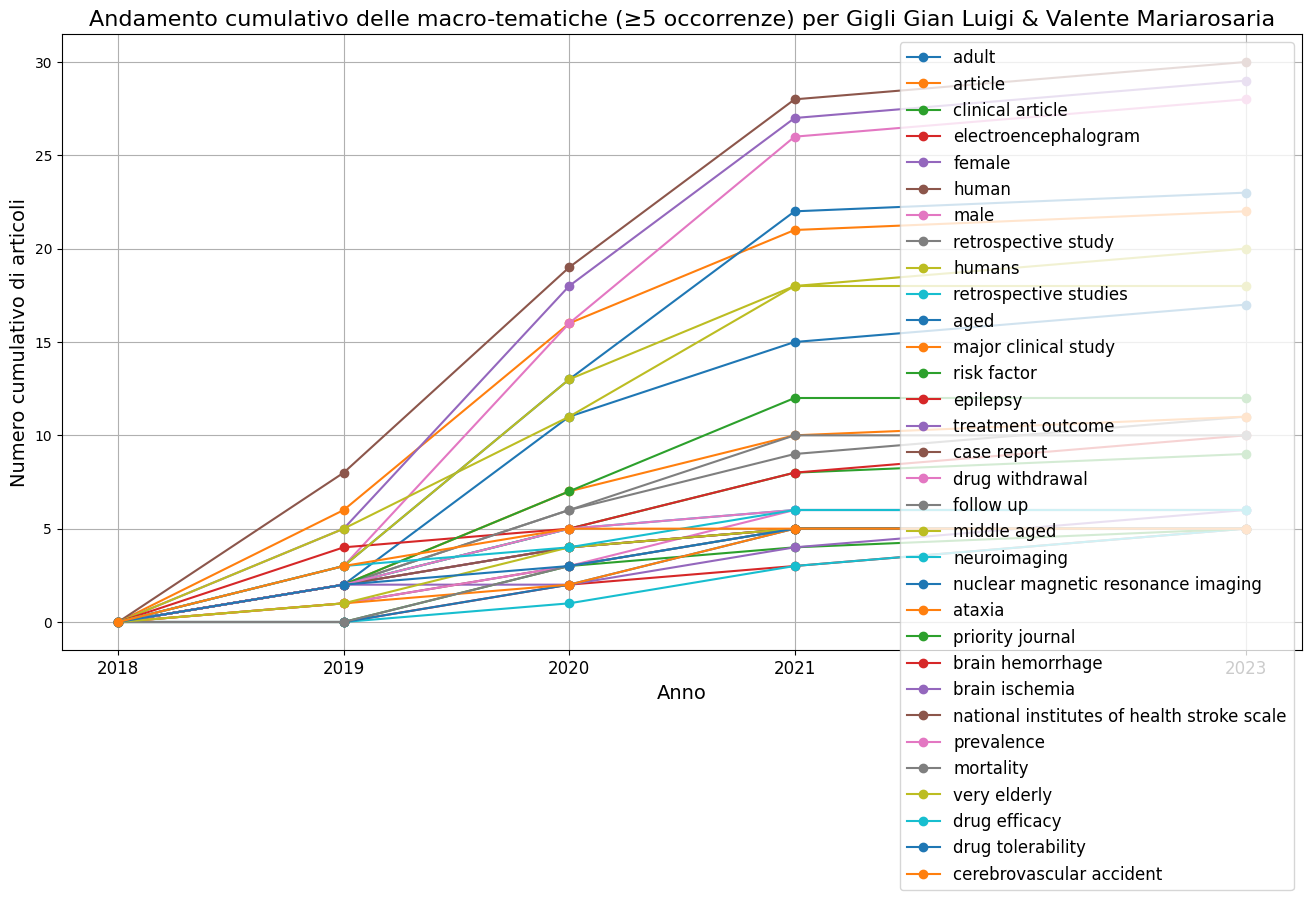

In [36]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# -------------------------
# Prendi la prima coppia da pairs_df
# -------------------------
if not pairs_df.empty:
    first_pair = pairs_df.iloc[0][["Author1","Author2"]].tolist()
else:
    print("pairs_df vuoto!")
    first_pair = []

target_authors = set(first_pair)
print("Autori selezionati:", target_authors)

# -------------------------
# Prepara index_keywords_list se non esiste
# -------------------------
if "index_kw_list" not in df.columns:
    def split_index_kw(x):
        if pd.isna(x):
            return []
        return [k.strip().lower() for k in str(x).split(";") if k.strip()]
    df["index_kw_list"] = df["Index Keywords"].apply(split_index_kw)

# -------------------------
# Filtra articoli contenenti entrambi gli autori
# -------------------------
mask = df["authors_list"].apply(lambda lst: target_authors.issubset(set(lst)))
df_pair = df.loc[mask]

if df_pair.empty:
    print("Nessun articolo trovato per questa coppia.")
else:
    # -------------------------
    # Conta tutte le keyword
    # -------------------------
    all_kw = [kw for kws in df_pair["index_kw_list"] for kw in kws]
    kw_counts = Counter(all_kw)

    # Applica soglia minima: almeno 5 occorrenze
    min_occurrences = 5
    top_keywords = [kw for kw, cnt in kw_counts.items() if cnt >= min_occurrences]

    if not top_keywords:
        print(f"Nessuna keyword compare almeno {min_occurrences} volte.")
    else:
        # -------------------------
        # Crea struttura anno -> keyword -> count
        # -------------------------
        data = {}
        for anno, df_anno in df_pair.groupby("Year"):
            if pd.isna(anno):
                continue
            counts = Counter([kw for kws in df_anno["index_kw_list"] for kw in kws])
            data[int(anno)] = {kw: counts.get(kw, 0) for kw in top_keywords}

        df_trend = pd.DataFrame(data).T.sort_index()

        # -------------------------
        # Aggiungi 2018 se mancante
        # -------------------------
        if 2018 not in df_trend.index:
            df_trend.loc[2018] = {kw: 0 for kw in top_keywords}
            df_trend = df_trend.sort_index()

        # -------------------------
        # Cumulativo anno per anno
        # -------------------------
        df_trend_cumsum = df_trend.cumsum()

        # -------------------------
        # Grafico
        # -------------------------
        plt.figure(figsize=(16,8))  # aumento delle dimensioni
        for kw in top_keywords:
            plt.plot(df_trend_cumsum.index, df_trend_cumsum[kw], marker='o', label=kw)

        plt.title(f"Andamento cumulativo delle macro-tematiche (≥{min_occurrences} occorrenze) per {first_pair[0]} & {first_pair[1]}", fontsize=16)
        plt.xlabel("Anno", fontsize=14)
        plt.ylabel("Numero cumulativo di articoli", fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)

        # Imposta gli anni consecutivi come xticks
        plt.xticks(sorted(df_trend_cumsum.index), fontsize=12)

        plt.show()


Autori selezionati: {'Valente Mariarosaria', 'Gigli Gian Luigi'}


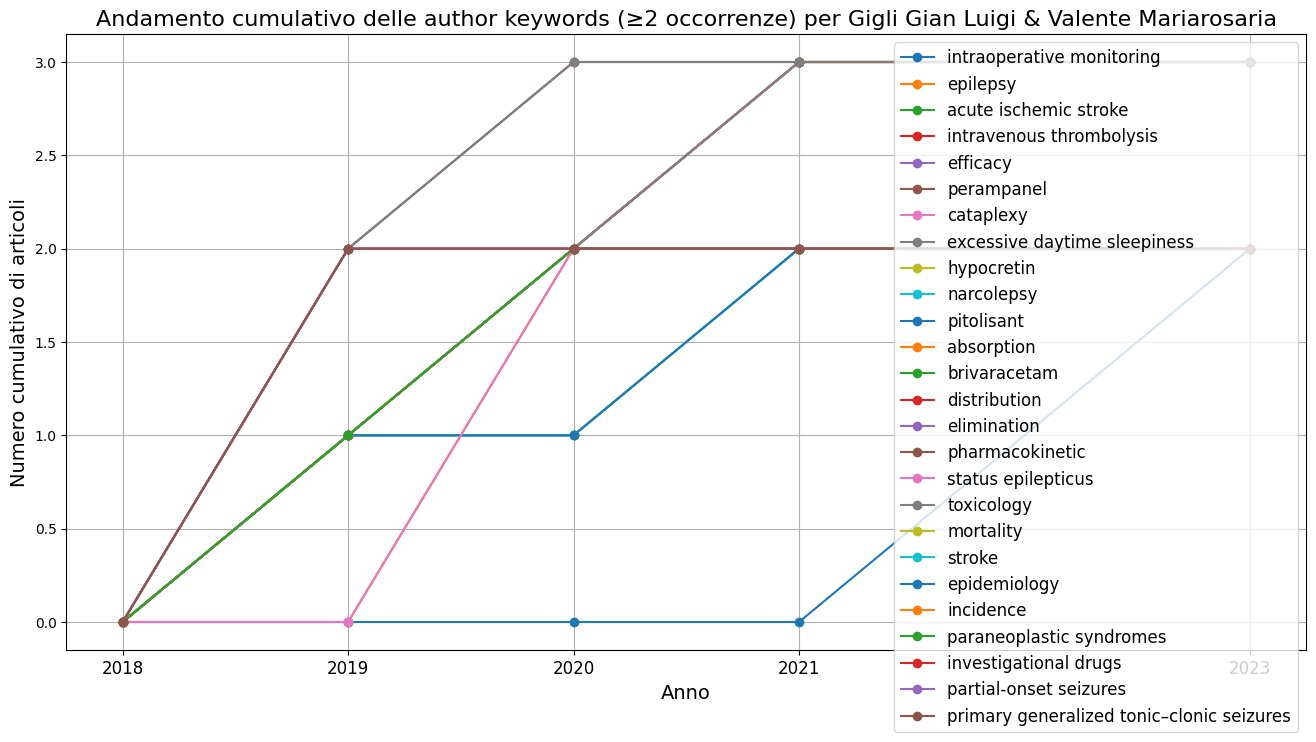

In [37]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# -------------------------
# Prendi la prima coppia da pairs_df
# -------------------------
if not pairs_df.empty:
    first_pair = pairs_df.iloc[0][["Author1","Author2"]].tolist()
else:
    print("pairs_df vuoto!")
    first_pair = []

target_authors = set(first_pair)
print("Autori selezionati:", target_authors)

# -------------------------
# Prepara author_keywords_list se non esiste
# -------------------------
if "author_kw_list" not in df.columns:
    def split_author_kw(x):
        if pd.isna(x):
            return []
        return [k.strip().lower() for k in str(x).split(";") if k.strip()]
    df["author_kw_list"] = df["Author Keywords"].apply(split_author_kw)

# -------------------------
# Filtra articoli contenenti entrambi gli autori
# -------------------------
mask = df["authors_list"].apply(lambda lst: target_authors.issubset(set(lst)))
df_pair = df.loc[mask]

if df_pair.empty:
    print("Nessun articolo trovato per questa coppia.")
else:
    # -------------------------
    # Conta tutte le author keywords
    # -------------------------
    all_kw = [kw for kws in df_pair["author_kw_list"] for kw in kws]
    kw_counts = Counter(all_kw)

    # Applica soglia minima: almeno 3 occorrenze
    min_occurrences = 2
    top_keywords = [kw for kw, cnt in kw_counts.items() if cnt >= min_occurrences]

    if not top_keywords:
        print(f"Nessuna author keyword compare almeno {min_occurrences} volte.")
    else:
        # -------------------------
        # Crea struttura anno -> keyword -> count
        # -------------------------
        data = {}
        for anno, df_anno in df_pair.groupby("Year"):
            if pd.isna(anno):
                continue
            counts = Counter([kw for kws in df_anno["author_kw_list"] for kw in kws])
            data[int(anno)] = {kw: counts.get(kw, 0) for kw in top_keywords}

        df_trend = pd.DataFrame(data).T.sort_index()

        # -------------------------
        # Aggiungi 2018 se mancante
        # -------------------------
        if 2018 not in df_trend.index:
            df_trend.loc[2018] = {kw: 0 for kw in top_keywords}
            df_trend = df_trend.sort_index()

        # -------------------------
        # Cumulativo anno per anno
        # -------------------------
        df_trend_cumsum = df_trend.cumsum()

        # -------------------------
        # Grafico
        # -------------------------
        plt.figure(figsize=(16,8))  # dimensione più grande
        for kw in top_keywords:
            plt.plot(df_trend_cumsum.index, df_trend_cumsum[kw], marker='o', label=kw)

        plt.title(f"Andamento cumulativo delle author keywords (≥{min_occurrences} occorrenze) per {first_pair[0]} & {first_pair[1]}", fontsize=16)
        plt.xlabel("Anno", fontsize=14)
        plt.ylabel("Numero cumulativo di articoli", fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=12)

        # Imposta gli anni consecutivi come xticks
        plt.xticks(sorted(df_trend_cumsum.index), fontsize=12)

        plt.show()


In [48]:
from pyvis.network import Network
import pandas as pd

df = pd.read_csv("nuovo_dataset.csv")

area_map = {
    "Lecture Notes in Computer Science": "Computer Science",
    "CEUR Workshop Proceedings": "Computer Science",
    "Theory and Practice of Logic Programming": "Computer Science",
    "Proceedings of Science": "Computer Science",
    "Journal of Physics: Conference Series": "Physics",
    "Challenges in Physics Education": "Physics",
    "Journal of Neurology": "Medicine",
    "Journal of Clinical Medicine": "Medicine",
    "Expert Opinion on Pharmacotherapy": "Pharmacology",
    "Expert Opinion on Drug Metabolism and Toxicology": "Pharmacology"
}

df["Area"] = df["Source title"].map(area_map).fillna("Other")

edges = (
    df.groupby(["Area", "Source title"])
    .size()
    .reset_index(name="weight")
)

net = Network(height="650px", width="100%", bgcolor="white")

for area in edges["Area"].unique():
    net.add_node(area, label=area, shape="ellipse", size=35)

for _, row in edges.iterrows():
    net.add_node(row["Source title"], label=row["Source title"], shape="box")
    net.add_edge(row["Area"], row["Source title"], value=row["weight"])

# 👇 usa QUESTO
net.save_graph("interdisciplinarita.html")


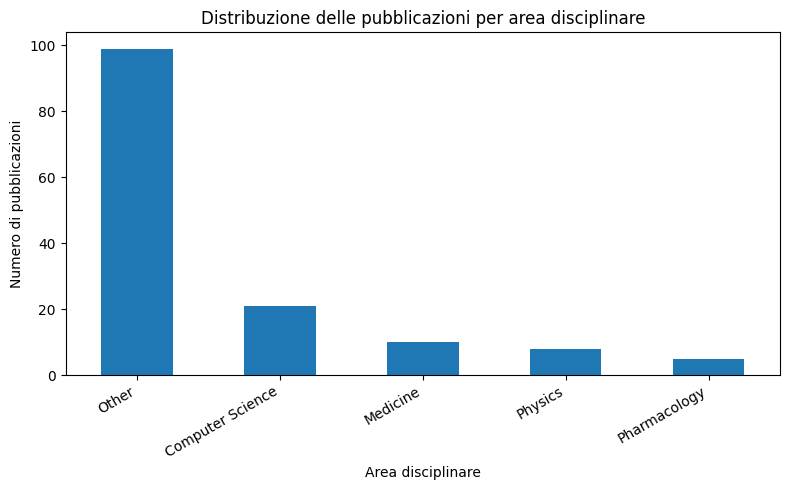

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("nuovo_dataset.csv")

area_map = {
    "Lecture Notes in Computer Science": "Computer Science",
    "CEUR Workshop Proceedings": "Computer Science",
    "Theory and Practice of Logic Programming": "Computer Science",
    "Proceedings of Science": "Computer Science",
    "Journal of Physics: Conference Series": "Physics",
    "Challenges in Physics Education": "Physics",
    "Journal of Neurology": "Medicine",
    "Journal of Clinical Medicine": "Medicine",
    "Expert Opinion on Pharmacotherapy": "Pharmacology",
    "Expert Opinion on Drug Metabolism and Toxicology": "Pharmacology"
}

df["Area"] = df["Source title"].map(area_map).fillna("Other")

area_counts = df["Area"].value_counts()

plt.figure(figsize=(8, 5))
area_counts.plot(kind="bar")
plt.xlabel("Area disciplinare")
plt.ylabel("Numero di pubblicazioni")
plt.title("Distribuzione delle pubblicazioni per area disciplinare")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [50]:
def infer_area(source):
    s = source.lower()

    if any(k in s for k in ["computer", "informatics", "logic", "workshop", "proceedings"]):
        return "Computer Science"

    if any(k in s for k in ["physics", "physical"]):
        return "Physics"

    if any(k in s for k in ["neurology", "clinical", "medicine", "medical"]):
        return "Medicine"

    if any(k in s for k in ["pharma", "drug", "toxicology", "metabolism"]):
        return "Pharmacology"

    return "Other"


In [53]:
from pyvis.network import Network
import pandas as pd

df = pd.read_csv("nuovo_dataset.csv")

df["Area"] = df["Source title"].fillna("").apply(infer_area)

edges = (
    df.groupby(["Area", "Source title"])
    .size()
    .reset_index(name="weight")
)

net = Network(
    height="650px",
    width="100%",
    bgcolor="white",
    font_color="black"
)

# nodi area
for area in edges["Area"].unique():
    net.add_node(
        area,
        label=area,
        shape="ellipse",
        size=35
    )

# nodi source + archi
for _, row in edges.iterrows():
    net.add_node(
        row["Source title"],
        label=row["Source title"],
        shape="box"
    )
    net.add_edge(
        row["Area"],
        row["Source title"],
        value=row["weight"]
    )

net.save_graph("interdisciplinarita_grafo.html")


In [52]:
import matplotlib.pyplot as plt

area_counts = df["Area"].value_counts()

plt.figure(figsize=(8, 5))
area_counts.plot(kind="bar")
plt.xlabel("Area disciplinare")
plt.ylabel("Numero di pubblicazioni")
plt.title("Distribuzione delle pubblicazioni per area disciplinare")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


KeyError: 'Area'

In [54]:
import pandas as pd
from pyvis.network import Network

# Caricamento dati
df = pd.read_csv("nuovo_dataset.csv")

def infer_area(title):
    title_low = str(title).lower()
    # Logica Math
    if any(k in title_low for k in ["math", "algebra", "logic", "discrete", "geometry", "analis", "matemat"]):
        return "Math"
    # Logica Science Computing (estesa per svuotare "Other")
    if any(k in title_low for k in ["computer", "algorithm", "informatic", "computing", "systems", 
                                    "intelligence", "ai", "software", "data", "cyber", "heuristics", 
                                    "automated planning", "acm", "ieee", "multimedia", "ceur", 
                                    "signal processing", "networks"]):
        return "Science computing"
    # Logica Medicine/Health
    if any(k in title_low for k in ["medicine", "neuro", "clinical", "drug", "health", "pharmac", 
                                    "genet", "cancer", "bio", "oncology", "epilepsy", "sleep", 
                                    "seizure", "cerebellum", "sclerosis", "thrombosis"]):
        return "Medicine/Health"
    # Logica Physics & Hard Sciences
    if any(k in title_low for k in ["physic", "nuclear", "chemical", "chemistry", "nanoscale", "molecule"]):
        return "Physics/Science"
    # Logica Engineering
    if any(k in title_low for k in ["engineering", "mechanical", "electrical", "transportation", "manufacturing"]):
        return "Engineering"
    
    return "Other"

# Applichiamo la classificazione
df["Area"] = df["Source title"].fillna("").apply(infer_area)

# Raggruppamento per pesi
edges = df.groupby(["Area", "Source title"]).size().reset_index(name="weight")

net = Network(height="750px", width="100%", bgcolor="white", font_color="black")

# Colori per macro-aree
colors = {
    "Math": "#ff7f0e", 
    "Science computing": "#1f77b4", 
    "Medicine/Health": "#d62728",
    "Physics/Science": "#2ca02c",
    "Engineering": "#9467bd",
    "Other": "#7f7f7f"
}

# 1. Aggiunta nodi Area
for area in edges["Area"].unique():
    net.add_node(area, label=area, shape="ellipse", size=40, color=colors.get(area, "#97c2fc"))

# 2. Aggiunta nodi Source + Archi verso le aree
for _, row in edges.iterrows():
    net.add_node(row["Source title"], label=row["Source title"], shape="box", size=15, color="#eeeeee")
    net.add_edge(row["Area"], row["Source title"], value=row["weight"], color=colors.get(row["Area"], "#848484"))

# 3. COLLEGAMENTO MANUALE tra Math e Science computing
net.add_edge("Math", "Science computing", weight=10, label="Interdisciplinary Connection", 
             color="black", width=4, dashes=True)

# Opzioni di layout per una migliore leggibilità
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": { "gravitationalConstant": -100, "springLength": 100 },
    "solver": "forceAtlas2Based",
    "stabilization": { "iterations": 100 }
  }
}
""")

net.save_graph("interdisciplinarita_grafo_migliorato.html")

In [55]:
import pandas as pd
from pyvis.network import Network

# 1. Caricamento del dataset
try:
    df = pd.read_csv("nuovo_dataset.csv")
except FileNotFoundError:
    print("Errore: Assicurati che il file 'nuovo_dataset.csv' sia nella stessa cartella dello script.")
    exit()

# 2. Funzione di classificazione avanzata (Riduzione "Other" e sviluppo "Punto 1")
def infer_area(title):
    t = str(title).lower()
    
    # Parole chiave per categoria
    kw_math = ["math", "algebra", "logic", "discrete", "geometry", "analis", "matemat", "combinatorics", "numerical"]
    kw_computing = ["computer", "algorithm", "informatic", "computing", "systems", "intelligence", "ai", 
                    "software", "data", "cyber", "heuristics", "acm", "ieee", "programming", "vision", "signal"]
    kw_med = ["medicine", "neuro", "clinical", "drug", "health", "pharmac", "genet", "cancer", "bio", 
              "oncology", "epilepsy", "sleep", "cerebellum", "sclerosis", "thrombosis", "physiolog"]
    
    # LOGICA "PUNTO 1": Intersezione Neuro-Informatica (Il Ponte)
    is_medical = any(k in t for k in kw_med)
    is_comp = any(k in t for k in kw_computing)
    
    if is_medical and is_comp:
        return "Neuro-Computing (Ponte)"
    
    # Classificazione standard
    if any(k in t for k in kw_math):
        return "Math"
    if is_comp:
        return "Science computing"
    if is_medical:
        return "Medicine/Health"
    if any(k in t for k in ["physic", "nuclear", "chemical", "nanoscale", "molecule", "science"]):
        return "Pure Sciences"
    if any(k in t for k in ["engineering", "mechanical", "electrical", "transportation", "manufacturing"]):
        return "Engineering"
    
    return "Other"

# Applicazione della logica
df["Area"] = df["Source title"].fillna("").apply(infer_area)

# 3. Preparazione dei dati per il grafo (Raggruppamento)
edges_data = df.groupby(["Area", "Source title"]).size().reset_index(name="weight")

# 4. Inizializzazione Rete Pyvis
net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black", heading="Grafo dell'Interdisciplinarità")

# Definizione colori per macro-aree
color_palette = {
    "Math": "#FFD700",                # Oro
    "Science computing": "#1E90FF",    # Blu
    "Neuro-Computing (Ponte)": "#FF4500", # Arancio/Rosso (Evidenziato)
    "Medicine/Health": "#32CD32",      # Verde
    "Pure Sciences": "#BA55D3",        # Viola
    "Engineering": "#808080",          # Grigio
    "Other": "#C0C0C0"                 # Argento
}

# 5. Aggiunta dei nodi Macro-Aree (Ellissi grandi)
for area in edges_data["Area"].unique():
    net.add_node(
        area, 
        label=area, 
        shape="ellipse", 
        size=45, 
        color=color_palette.get(area, "#97c2fc"),
        font={'size': 25, 'face': 'Arial', 'weight': 'bold'}
    )

# 6. Aggiunta dei nodi Riviste (Box piccoli) e archi
for _, row in edges_data.iterrows():
    source = row["Source title"]
    area = row["Area"]
    weight = row["weight"]
    
    # Nodo Rivista
    net.add_node(
        source, 
        label=source, 
        shape="box", 
        size=15, 
        color="#eeeeee",
        font={'size': 12}
    )
    
    # Arco Area -> Rivista
    net.add_edge(
        area, 
        source, 
        value=weight, 
        title=f"Occorrenze: {weight}",
        color=color_palette.get(area, "#848484"),
        alpha=0.6
    )

# 7. COLLEGAMENTI INTERDISCIPLINARI (I "Ponti")
# Collegamento richiesto: Math -> Science Computing
net.add_edge(
    "Math", "Science computing", 
    label="Fondamenti Matematici", 
    weight=15, 
    color="#000000", 
    width=5, 
    dashes=True
)

# Collegamento Punto 1: Science Computing -> Neuro-Computing
net.add_edge(
    "Science computing", "Neuro-Computing (Ponte)", 
    label="Algoritmi Neurali", 
    weight=10, 
    color="#FF4500", 
    width=3
)

# 8. Configurazione Fisica per un layout pulito
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -150,
      "centralGravity": 0.005,
      "springLength": 150,
      "springStrength": 0.05
    },
    "solver": "forceAtlas2Based",
    "stabilization": { "iterations": 150 }
  },
  "interaction": {
    "hover": true,
    "navigationButtons": true
  }
}
""")

# 9. Salvataggio e generazione del file
net.save_graph("grafo_interdisciplinare_finale.html")
print("Grafo generato con successo: apri 'grafo_interdisciplinare_finale.html' nel tuo browser.")

Grafo generato con successo: apri 'grafo_interdisciplinare_finale.html' nel tuo browser.


In [56]:
import pandas as pd
from pyvis.network import Network

# 1. Caricamento dati
df = pd.read_csv("nuovo_dataset.csv")

# 2. Definizione dei Dizionari di Keywords per Macro-Area
# Puoi aggiungere o modificare queste parole per affinare la precisione
categories_map = {
    "Math": [
        "graph theory", "combinatorics", "optimization", "algebra", "logic", 
        "discrete mathematics", "topology", "geometry", "calculus", "numerical analysis"
    ],
    "Science computing": [
        "machine learning", "artificial intelligence", "algorithms", "neural networks", 
        "deep learning", "software", "data mining", "computer vision", "heuristics",
        "cybersecurity", "big data", "cloud computing", "iot"
    ],
    "Medicine/Health": [
        "neurology", "epilepsy", "clinical", "biomedical", "brain", "genetics", 
        "pharmacology", "therapy", "oncology", "patient", "eeg", "mri", "healthcare"
    ],
    "Physics/Engineering": [
        "physics", "mechanics", "thermodynamics", "electronics", "control systems", 
        "robotics", "nanotechnology", "nuclear", "material science", "fluid dynamics"
    ]
}

def classify_by_keywords(row):
    # Uniamo keywords degli autori e titoli per sicurezza
    keywords = str(row["Author Keywords"]).lower()
    title = str(row["Source title"]).lower()
    content = keywords + " " + title
    
    found_areas = []
    
    for area, keywords_list in categories_map.items():
        if any(k in content for k in keywords_list):
            found_areas.append(area)
    
    # Logica "Punto 1": Se troviamo sia elementi medici che informatici
    if "Medicine/Health" in found_areas and "Science computing" in found_areas:
        return ["Neuro-Computing (Ponte)"]
    
    return found_areas if found_areas else ["Other"]

# 3. Trasformazione del Dataset
# Esplodiamo le righe: se un articolo ha 2 aree, creiamo 2 connessioni nel grafo
df["Areas"] = df.apply(classify_by_keywords, axis=1)
df_exploded = df.explode("Areas")

# 4. Creazione del Grafo
net = Network(height="800px", width="100%", bgcolor="white", font_color="black")

colors = {
    "Math": "#FFD700",
    "Science computing": "#1E90FF",
    "Neuro-Computing (Ponte)": "#FF4500",
    "Medicine/Health": "#32CD32",
    "Physics/Engineering": "#BA55D3",
    "Other": "#C0C0C0"
}

# Aggiunta nodi Macro-Aree
for area, color in colors.items():
    net.add_node(area, label=area, shape="ellipse", size=50, color=color, font={'size': 30})

# Aggiunta nodi Journal e Archi
edges = df_exploded.groupby(["Areas", "Source title"]).size().reset_index(name="weight")

for _, row in edges.iterrows():
    # Nodo Journal (se non esiste già)
    net.add_node(row["Source title"], label=row["Source title"], shape="box", size=15, color="#f0f0f0")
    
    # Arco verso la macro-area basata sulle keywords
    net.add_edge(
        row["Areas"], 
        row["Source title"], 
        value=row["weight"], 
        color=colors.get(row["Areas"], "#848484")
    )

# Collegamento manuale richiesto Math <-> Science Computing
net.add_edge("Math", "Science computing", label="Interdisciplinary", color="black", width=3, dashes=True)

# Opzioni di layout
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": { "gravitationalConstant": -150, "springLength": 120 },
    "solver": "forceAtlas2Based",
    "stabilization": { "iterations": 150 }
  }
}
""")

net.save_graph("grafo_keywords_precision.html")
print("Grafo generato con successo basandosi sulle Author Keywords.")

Grafo generato con successo basandosi sulle Author Keywords.


In [57]:
import pandas as pd
from pyvis.network import Network

# 1. Caricamento dati
df = pd.read_csv("nuovo_dataset.csv")

# 2. Espansione del Dizionario (Più termini = Meno "Other")
categories_map = {
    "Math": [
        "math", "algebra", "logic", "discrete", "geometry", "analis", "matemat", 
        "combinatorics", "graph theory", "set theory", "formal proofs", "optimization",
        "calculus", "numerical", "complexity"
    ],
    "Science computing": [
        "computer", "algorithm", "informatic", "computing", "systems", "intelligence", 
        "ai", "software", "data", "cyber", "heuristics", "ceur", "acm", "ieee", 
        "machine learning", "deep learning", "neural net", "signal processing", 
        "vision", "image", "cloud", "iot", "programming", "simulation"
    ],
    "Medicine/Health": [
        "medicine", "neuro", "clinical", "drug", "health", "pharmac", "genet", 
        "cancer", "bio", "oncology", "epilepsy", "sleep", "seizure", "cerebellum", 
        "sclerosis", "thrombosis", "brain", "patient", "therapy", "medical"
    ],
    "Physics/Hard Science": [
        "physic", "nuclear", "chemical", "chemistry", "nanoscale", "molecule", 
        "material", "energy", "atoms", "mechanics", "astronomy", "scientific"
    ],
    "Engineering": [
        "engineering", "mechanical", "electrical", "transportation", "manufacturing", 
        "robotics", "control", "automation", "electronics", "sensors"
    ]
}

def classify_row(row):
    # Uniamo tutte le fonti di testo disponibili per ogni riga
    text_sources = [
        str(row.get("Author Keywords", "")),
        str(row.get("Index Keywords", "")),
        str(row.get("Source title", ""))
    ]
    content = " ".join(text_sources).lower()
    
    found_areas = []
    
    # Controllo delle categorie
    for area, keywords in categories_map.items():
        if any(k in content for k in keywords):
            found_areas.append(area)
    
    # Logica Speciale: Neuro-Computing (Punto 1)
    if "Medicine/Health" in found_areas and "Science computing" in found_areas:
        return ["Neuro-Computing (Ponte)"]
    
    # Se non trova nulla, restituisce "Other"
    return found_areas if found_areas else ["Other"]

# 3. Applicazione e preparazione dati
df["Areas"] = df.apply(classify_row, axis=1)
df_exploded = df.explode("Areas")

# 4. Creazione Grafo
net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="black")

# Palette colori
colors = {
    "Math": "#FFD700",
    "Science computing": "#1E90FF",
    "Neuro-Computing (Ponte)": "#FF4500",
    "Medicine/Health": "#32CD32",
    "Physics/Hard Science": "#BA55D3",
    "Engineering": "#FF69B4",
    "Other": "#A9A9A9" # Grigio per i pochi rimasti
}

# Aggiunta nodi Area
for area, color in colors.items():
    net.add_node(area, label=area, shape="ellipse", size=50, color=color, font={'size': 30, 'weight': 'bold'})

# Raggruppamento per archi
edges = df_exploded.groupby(["Areas", "Source title"]).size().reset_index(name="weight")

# Aggiunta nodi Riviste e Archi
for _, row in edges.iterrows():
    net.add_node(row["Source title"], label=row["Source title"], shape="box", size=15, color="#f0f0f0")
    net.add_edge(row["Areas"], row["Source title"], value=row["weight"], color=colors.get(row["Areas"], "#848484"))

# Collegamento manuale richiesto: Math <-> Computing
net.add_edge("Math", "Science computing", label="Interdisciplinary Link", color="#000000", width=4, dashes=True)

# Opzioni di layout
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": { "gravitationalConstant": -120, "springLength": 150 },
    "solver": "forceAtlas2Based"
  }
}
""")

net.save_graph("grafo_no_other.html")
print("Grafo salvato. La sezione 'Other' dovrebbe essere ora minima.")

Grafo salvato. La sezione 'Other' dovrebbe essere ora minima.


In [58]:
import pandas as pd
from pyvis.network import Network

# 1. Caricamento del dataset
df = pd.read_csv("nuovo_dataset.csv")

# 2. Definizione Macro-Aree basata esclusivamente su Index Keywords
# Usiamo i nomi delle aree come "filtri" per scansionare la colonna Index Keywords
def classify_by_index(index_text):
    text = str(index_text).lower()
    if text == "nan" or not text.strip():
        return ["Other"]
    
    found_areas = []
    
    # Mappatura diretta: cerchiamo la radice dell'area nelle Index Keywords
    mapping = {
        "Math": ["math", "algebra", "logic", "combinatorics", "graph theory", "geometry"],
        "Science computing": ["computer", "algorithm", "intelligence", "data", "software", "computing"],
        "Medicine/Health": ["medicine", "neuro", "clinical", "biomedical", "health", "pharmac"],
        "Physics": ["physics", "nuclear", "energy", "matter"],
        "Engineering": ["engineering", "mechanical", "electrical", "control", "systems"]
    }
    
    for area, roots in mapping.items():
        if any(root in text for root in roots):
            found_areas.append(area)
            
    # Punto 1: Se un articolo ha sia termini "neuro/med" che "comp/alg" nelle Index Keywords
    if "Medicine/Health" in found_areas and "Science computing" in found_areas:
        return ["Neuro-Computing (Ponte)"]
        
    return found_areas if found_areas else ["Other"]

# 3. Trasformazione: Ogni riga può appartenere a più aree (Interdisciplinarità)
df["Areas"] = df["Index Keywords"].apply(classify_by_index)
df_exploded = df.explode("Areas")

# 4. Creazione del Grafo con Pyvis
net = Network(height="750px", width="100%", bgcolor="white", font_color="black")

# Colori assegnati alle macro-aree
colors = {
    "Math": "#FFD700",
    "Science computing": "#1E90FF",
    "Neuro-Computing (Ponte)": "#FF4500",
    "Medicine/Health": "#32CD32",
    "Physics": "#BA55D3",
    "Engineering": "#FF69B4",
    "Other": "#C0C0C0"
}

# Aggiunta nodi Macro-Aree
for area, color in colors.items():
    net.add_node(area, label=area, shape="ellipse", size=50, color=color, font={'size': 25, 'weight': 'bold'})

# Raggruppamento per generare i pesi degli archi
# (Quante volte un Journal è indicizzato in quella macro-area?)
edges = df_exploded.groupby(["Areas", "Source title"]).size().reset_index(name="weight")

for _, row in edges.iterrows():
    # Nodo Rivista
    net.add_node(row["Source title"], label=row["Source title"], shape="box", size=15, color="#f0f0f0")
    # Arco dalla Macro-Area alla Rivista
    net.add_edge(
        row["Areas"], 
        row["Source title"], 
        value=row["weight"], 
        color=colors.get(row["Areas"], "#848484"),
        title=f"Basato su Index Keywords: {row['weight']} occorrenze"
    )

# Collegamento tra Math e Science Computing (richiesto)
net.add_edge("Math", "Science computing", label="Fondamenti", color="black", width=3, dashes=True)

# 5. Configurazione Layout
net.set_options("""
var options = {
  "physics": {
    "forceAtlas2Based": { "gravitationalConstant": -100, "springLength": 150 },
    "solver": "forceAtlas2Based",
    "stabilization": { "iterations": 100 }
  }
}
""")

net.save_graph("grafo_index_keywords.html")
print("Grafo generato utilizzando esclusivamente la colonna 'Index Keywords'.")

Grafo generato utilizzando esclusivamente la colonna 'Index Keywords'.


In [60]:
#ODICE LISTA ESTERE VS ITALIANE: 
import pandas as pd
import re

# ----------------------------------
# 1. CARICAMENTO
# ----------------------------------

df = pd.read_csv("nuovo_dataset.csv")

# Assicurati che ci sia una colonna Affiliations
df = df.dropna(subset=["Affiliations"])

# Separa autori e affiliazioni in strutture
# (dipende da come sono formattate: qui assumiamo delimitate da ';')
df["AffiliationsList"] = df["Affiliations"].str.split(";")

# ----------------------------------
# 2. TROVA PAPER CON UDINE
# ----------------------------------

def is_udine_aff(aff):
    return bool(re.search(r"\bUdine\b", aff, flags=re.IGNORECASE))

# tutti i paper con almeno una affiliazione Udine
df_udine = df[df["AffiliationsList"].apply(lambda affs: any(is_udine_aff(a) for a in affs))]

# ----------------------------------
# 3. ESTRAI TUTTE LE COLLABORAZIONI
# ----------------------------------

collab_affiliations = []

for idx, row in df_udine.iterrows():
    for aff in row["AffiliationsList"]:
        aff_clean = aff.strip()
        if not is_udine_aff(aff_clean):
            collab_affiliations.append(aff_clean)

# ----------------------------------
# 4. CLASSIFICA ITALIANE VS ESTERE
# ----------------------------------

def classify_affiliation(aff):
    aff = aff.lower()
    if "italy" in aff or aff.endswith("italy"):
        return "Italian"
    else:
        return "Foreign"

collab_df = pd.DataFrame({
    "Affiliation": collab_affiliations
})

collab_df["Type"] = collab_df["Affiliation"].apply(classify_affiliation)

# ----------------------------------
# 5. RISULTATI: STATISTICHE
# ----------------------------------

italian_collabs = collab_df[collab_df["Type"] == "Italian"]
foreign_collabs = collab_df[collab_df["Type"] == "Foreign"]

print("Numero collaborazioni italiane:", italian_collabs.shape[0])
print("Numero collaborazioni estere:", foreign_collabs.shape[0])

print("\nTop 10 istituzioni italiane:")
print(italian_collabs["Affiliation"].value_counts().head(10))

print("\nTop 10 istituzioni estere:")
print(foreign_collabs["Affiliation"].value_counts().head(10))

Numero collaborazioni italiane: 93
Numero collaborazioni estere: 185

Top 10 istituzioni italiane:
Affiliation
Università degli Studi di Padova, Padua, PD, Italy                                                           7
Istituto Nazionale di Fisica Nucleare, Sezione di Trieste, Trieste, TS, Italy                                5
Department of Diagnostic Imaging, Fondazione Poliambulanza Istituto Ospedaliero, Brescia, Italy              4
Università degli Studi di Trieste, Trieste, TS, Italy                                                        3
Istituto Nazionale di Biostrutture e Biosistemi, Rome, RM, Italy                                             3
Department of Neurological Sciences, Università Vita-Salute San Raffaele, Milan, MI, Italy                   3
Department of Medical Sciences and Public Health, Università degli Studi di Cagliari, Cagliari, CA, Italy    3
Politecnico di Milano, Milan, MI, Italy                                                                      3
T

In [72]:
import pandas as pd
import networkx as nx
import re
import plotly.graph_objects as go

# =====================================
# 1. CARICAMENTO E PULIZIA
# =====================================
df = pd.read_csv("nuovo_dataset.csv")
df = df.dropna(subset=["Affiliations"])
df["AffiliationsList"] = df["Affiliations"].str.split(";")

# 2. IDENTIFICAZIONE UDINE
def is_udine(aff):
    return bool(re.search(r"\bUdine\b", str(aff), re.IGNORECASE))

df_udine = df[df["AffiliationsList"].apply(lambda affs: any(is_udine(a) for a in affs))]

# 3. ESTRAZIONE COLLABORAZIONI
collaborations = []
for _, row in df_udine.iterrows():
    for aff in row["AffiliationsList"]:
        aff = aff.strip()
        if not is_udine(aff):
            collaborations.append(aff)

# 4. CLASSIFICAZIONE E CONTEGGIO
def classify_affiliation(aff):
    return "Italian" if "italy" in aff.lower() else "Foreign"

collab_df = pd.DataFrame({"Affiliation": collaborations})
collab_df["Type"] = collab_df["Affiliation"].apply(classify_affiliation)
collab_counts = collab_df.groupby(["Affiliation", "Type"]).size().reset_index(name="weight")
collab_counts = collab_counts[collab_counts["weight"] >= 2]

# =====================================
# 5. COSTRUZIONE GRAFO
# =====================================
G = nx.Graph()
G.add_node("University of Udine", role="udine")
for _, row in collab_counts.iterrows():
    G.add_node(row["Affiliation"], role=row["Type"], weight=row["weight"])
    G.add_edge("University of Udine", row["Affiliation"], weight=row["weight"])

pos = nx.spring_layout(G, seed=42)

# =====================================
# 6. TRACCE PLOTLY
# =====================================
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

# Traccia Collegamento (Legenda Linea)
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines',
    showlegend=True,
    name='Collaborazioni'
)

node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
for node, data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>Collaborazioni: {data.get('weight', 0)}")
    role = data["role"]
    node_color.append('red' if role=="udine" else 'skyblue' if role=="Italian" else 'orange')
    size = 25 if role=="udine" else 10 + 5 * data.get('weight', 1)
    node_size.append(size)

# Traccia Nodi (Senza duplicato in legenda)
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    text=node_text,
    hoverinfo='text',
    marker=dict(color=node_color, size=node_size, line_width=1.5),
    showlegend=False
)

# Legenda Personalizzata
legend_traces = [
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=12, color='red'), name='Udine'),
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=12, color='skyblue'), name='Italia'),
    go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=12, color='orange'), name='Estero')
]

# =====================================
# 7. VISUALIZZAZIONE GRAFO
# =====================================
fig = go.Figure(data=[edge_trace, node_trace] + legend_traces,
                layout=go.Layout(
                    title="Collaborazioni dell’Università di Udine (Italia vs Estero)",
                    title_x=0.5,
                    showlegend=True,
                    legend=dict(x=1.02, y=0.95, bordercolor="Black", borderwidth=1),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    margin=dict(l=50, r=200, t=80, b=50),
                    hovermode='closest'
                )
)

fig.show()

# =====================================
# 8. TABELLA TOP 3 (TUTTO A SINISTRA)
# =====================================
top_italy = collab_counts[collab_counts["Type"]=="Italian"].sort_values(by="weight", ascending=False).head(3)
top_foreign = collab_counts[collab_counts["Type"]=="Foreign"].sort_values(by="weight", ascending=False).head(3)

# Funzione per forzare l'allineamento a sinistra di ogni colonna
def print_left_aligned(df, title):
    print(f"\n{title}")
    # Convertiamo tutto in stringa per evitare allineamenti numerici a destra
    df_str = df[['Affiliation', 'weight']].astype(str)
    # Calcoliamo la larghezza massima per ogni colonna
    widths = [df_str[col].str.len().max() for col in df_str.columns]
    headers = df_str.columns
    
    # Stampa Intestazioni
    header_row = "  ".join([h.ljust(widths[i]) for i, h in enumerate(headers)])
    print(header_row)
    print("-" * len(header_row))
    
    # Stampa Righe
    for _, row in df_str.iterrows():
        print("  ".join([row[col].ljust(widths[i]) for i, col in enumerate(df_str.columns)]))

print("\n" + "="*60)
print("--- CLASSIFICA TOP 3 COLLABORAZIONI ---")
print("="*60)

print_left_aligned(top_italy, "ITALIA:")
print_left_aligned(top_foreign, "ESTERO:")


--- CLASSIFICA TOP 3 COLLABORAZIONI ---

ITALIA:
Affiliation                                                                                      weight
-------------------------------------------------------------------------------------------------------
Università degli Studi di Padova, Padua, PD, Italy                                               7
Istituto Nazionale di Fisica Nucleare, Sezione di Trieste, Trieste, TS, Italy                    5
Department of Diagnostic Imaging, Fondazione Poliambulanza Istituto Ospedaliero, Brescia, Italy  4

ESTERO:
Affiliation                                                                                     weight
------------------------------------------------------------------------------------------------------
Universitat Politècnica de València, Valencia, Valencia, Spain                                  7
University of Oxford Medical Sciences Division, Oxford, Oxfordshire, United Kingdom             6
Division of Science and Mathematic